# Calgary Stampeders - Event Propensity MVP
* StellarAlgo Data Science
* Nakisa Rad & Ryan Kazmerik
* May 26, 2022

## Hypothesis
We think that using our Stellar Event Propensity model, we can produce a list of fans that have higher probability to purchase a individual ticket to a game based on their previous purchasing and engagement behaviour.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import boto3
import getpass
import pyodbc
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

from pycaret.classification import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

MZNX-CQQN
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [3]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'prod-app'
DBNAME = 'stlrcfl'

creds = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

# create a connection & cursor and call the stored procedure
conn = psycopg2.connect(
    host = 'prod-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds['DbUser'],
    password = creds['DbPassword'],
    database = DBNAME
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: prod-app stlrcfl


### Let's connect to Redshift and run a stored proc to get our dataset:

In [4]:
cur = conn.cursor()
cur.execute(f"CALL ds.geteventpropensitytrainingdata(35, 2010, 2021, 'rkcursor')")

# create a named cursor based on the cursor name passed in above
named_cursor = conn.cursor('rkcursor')
data = named_cursor.fetchall()

# load the data and columns into a data frame
cols = [row[0] for row in named_cursor.description]
df = pd.DataFrame(data=data, columns=cols)

conn.commit()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16928 entries, 0 to 16927
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   daysout              16928 non-null  object        
 1   mindaysout           16928 non-null  int64         
 2   maxdaysout           10451 non-null  float64       
 3   dimcustomermasterid  16928 non-null  int64         
 4   recent_openrate      16928 non-null  float64       
 5   recent_clickrate     16928 non-null  float64       
 6   eventdate            16928 non-null  datetime64[ns]
 7   eventname            16928 non-null  object        
 8   inmarket             15417 non-null  object        
 9   distancetovenue      15417 non-null  float64       
 10  tenure               16928 non-null  int64         
 11  did_purchase         16928 non-null  int64         
 12  events_purchased     16928 non-null  int64         
 13  frequency_opponent   16928 non-

In [6]:
# choose the features for the stellar base retention model
features = [
                "daysout",
                #"mindaysout",
                #"maxdaysout",
                "dimcustomermasterid",
                "recent_openrate",
                "recent_clickrate",
                "eventdate",
                #"eventname",
                "inmarket",
                "distancetovenue",
                "tenure",
                "did_purchase",
                "events_purchased",
                "frequency_opponent",
                "frequency_eventday",
                "frequency_eventtime"
                #"count_merchowned"
]

# copy your main dataframe
df_dataset = df

#creating the training and evaluation dataframe
df_dataset = df_dataset[features]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14389, 13)
Unseen Data For Predictions: (2539, 13)



### Now we can model the data using a binary classification prediction for the did_purchase field to see how likely a customer is to re-purchase.

In [7]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimcustomermasterid"],
    silent=True,
    verbose=False,
    numeric_features=[
        
                #"mindaysout",
                #"maxdaysout",
                "recent_openrate",
                "recent_clickrate",
                "distancetovenue",
                "tenure",
                "events_purchased",
                "frequency_opponent",
                "frequency_eventday",
                "frequency_eventtime"
                #"count_merchowned"
    ]
);

In [8]:
model_matrix = compare_models(
    fold=10,
    include=["dt", "gbc", "lightgbm", "lr", "rf", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8065,0.8886,0.7813,0.8216,0.8007,0.6130,0.6140,0.8030
lightgbm,Light Gradient Boosting Machine,0.7817,0.8689,0.7616,0.7926,0.7765,0.5633,0.5641,0.0710
gbc,Gradient Boosting Classifier,0.7414,0.8234,0.7177,0.7517,0.7342,0.4826,0.4832,0.2850
rf,Random Forest Classifier,0.7310,0.8114,0.7005,0.7442,0.7216,0.4618,0.4627,0.3120
dt,Decision Tree Classifier,0.7081,0.7085,0.6834,0.7171,0.6998,0.4160,0.4166,0.3400
lr,Logistic Regression,0.6894,0.7630,0.6563,0.7007,0.6777,0.3785,0.3794,0.1470


In [9]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7997,0.8834,0.7816,0.8095,0.7953,0.5993,0.5996
1,0.8324,0.9123,0.7964,0.8569,0.8255,0.6647,0.6663
2,0.8005,0.8789,0.7865,0.8078,0.7970,0.6009,0.6011
3,0.8029,0.8863,0.7964,0.8056,0.8010,0.6059,0.6059
4,0.8038,0.8824,0.7833,0.8154,0.7990,0.6075,0.6079
5,0.8021,0.8834,0.7931,0.8063,0.7997,0.6042,0.6043
6,0.8201,0.8977,0.7714,0.8527,0.8100,0.6400,0.6429
7,0.8095,0.8919,0.7928,0.8183,0.8053,0.6189,0.6192
8,0.8078,0.8898,0.7796,0.8243,0.8014,0.6156,0.6165
9,0.7866,0.8802,0.7319,0.8195,0.7732,0.5729,0.5762


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

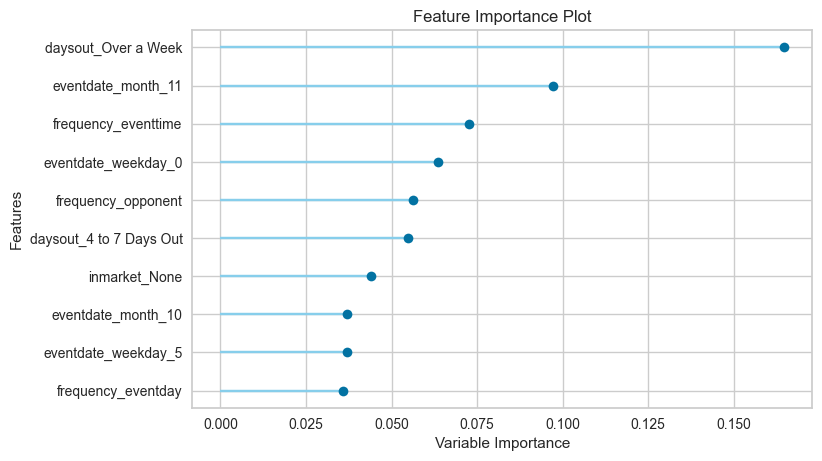

In [10]:
plot_model(final_model, plot='feature')

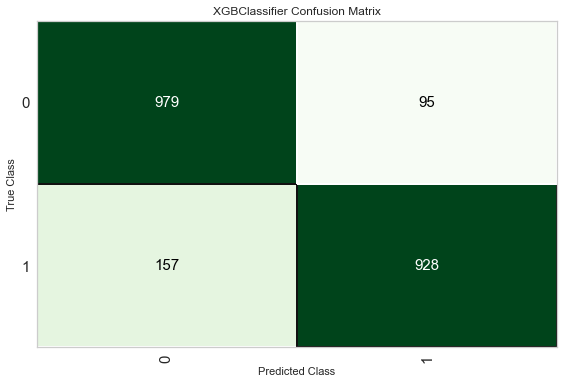

In [11]:
plot_model(final_model, plot='confusion_matrix')

### To connect to RedShift, we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

### Now we can create a session and client to RedShift, and create a new connection using Psycopg2:

### First we need to call the stored procedure, which will create a named cursor - then we can query the results produced by the stored proc using that named cursor to create scoring dataframe:

In [31]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'prod-app'
DBNAME = 'stlrcfl'

creds2 = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

# create a connection & cursor and call the stored procedure
conn2 = psycopg2.connect(
    host = 'prod-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds2['DbUser'],
    password = creds2['DbPassword'],
    database = DBNAME
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: prod-app stlrcfl


In [32]:
# create a list of games dates 
game_dates= ['2022-06-09','2022-06-25','2022-07-30','2022-08-13','2022-09-05','2022-09-17','2022-10-01','2022-10-14','2022-10-29']

predictions =[]
for game_date in game_dates:
    
    cur2 = conn2.cursor()
    cur2.execute(f"CALL ds.geteventpropensityscoringdata(35, '{game_date}', 'result')")

    # create a named cursor based on the cursor name passed in above
    named_cursor = conn2.cursor('result')
    data = named_cursor.fetchall()

    # load the data and columns into a data frame
    cols = [row[0] for row in named_cursor.description]
    df_scoring = pd.DataFrame(data=data, columns=cols)
    df_scoring = df_scoring.fillna(0)
    #print(df_scoring)
    
    # get predictions from the model for each game
    new_predictions = predict_model(final_model, data=df_scoring, raw_score=True)
    predictions.append(new_predictions)
    
    conn2.commit()

In [34]:
for df_game in predictions:
    print(str(df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")) + '\n' + str(df_game["Score_1"].value_counts(bins=[0, 0.5, 0.8, 1.0])))

06-09-2022
(0.8, 1.0]       41863
(-0.001, 0.5]    20615
(0.5, 0.8]       20026
Name: Score_1, dtype: int64
06-25-2022
(0.8, 1.0]       55365
(0.5, 0.8]       15540
(-0.001, 0.5]    11599
Name: Score_1, dtype: int64
07-30-2022
(0.8, 1.0]       52939
(0.5, 0.8]       16601
(-0.001, 0.5]    12964
Name: Score_1, dtype: int64
08-13-2022
(0.8, 1.0]       57521
(0.5, 0.8]       13881
(-0.001, 0.5]    11102
Name: Score_1, dtype: int64
09-05-2022
(0.8, 1.0]       47560
(0.5, 0.8]       20810
(-0.001, 0.5]    14134
Name: Score_1, dtype: int64
09-17-2022
(0.8, 1.0]       53613
(0.5, 0.8]       16211
(-0.001, 0.5]    12680
Name: Score_1, dtype: int64
10-01-2022
(0.8, 1.0]       62893
(0.5, 0.8]       11095
(-0.001, 0.5]     8516
Name: Score_1, dtype: int64
10-14-2022
(0.8, 1.0]       53641
(0.5, 0.8]       15366
(-0.001, 0.5]    13497
Name: Score_1, dtype: int64
10-29-2022
(0.8, 1.0]       63827
(0.5, 0.8]       10609
(-0.001, 0.5]     8068
Name: Score_1, dtype: int64


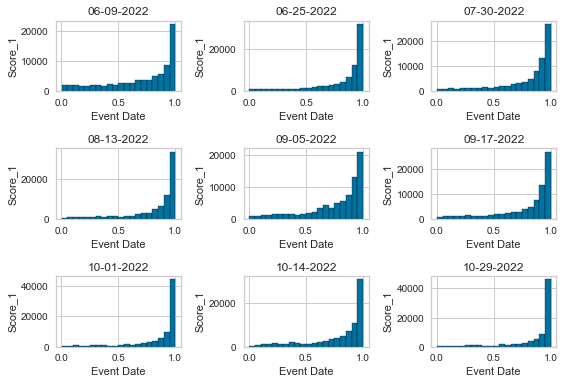

In [36]:
for idx, df_game in enumerate(predictions):
    
    plt.subplot(3, 3, idx+1)
    
    event_date = df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")
    
    plt.title(event_date, fontsize = 12)
    plt.xlabel("Event Date")
    plt.ylabel("Score_1")
    plt.hist(df_game['Score_1'], bins= 20, edgecolor = "black")
plt.tight_layout()
plt.show()

In [38]:
for df_game in predictions:
    print(df_game["eventdate"].value_counts().sort_index(ascending=False))

2022-06-09    82504
Name: eventdate, dtype: int64
2022-06-25    82504
Name: eventdate, dtype: int64
2022-07-30    82504
Name: eventdate, dtype: int64
2022-08-13    82504
Name: eventdate, dtype: int64
2022-09-05    82504
Name: eventdate, dtype: int64
2022-09-17    82504
Name: eventdate, dtype: int64
2022-10-01    82504
Name: eventdate, dtype: int64
2022-10-14    82504
Name: eventdate, dtype: int64
2022-10-29    82504
Name: eventdate, dtype: int64


### Save the results in for each game in a csv file

In [39]:
for df_game in predictions:

    event_date = df_game['eventdate'].unique()[0].strftime("%m-%d-%Y")
    df_game.to_csv(f"prod_results_redshift/stamps_ep_scores_{event_date}.csv", index=False)

## Observations

1. How accurate was this model? 
* The accuracy is 80% 

2. How many fans scored over 0.80 for the 2022 season?
* 06-09-2022 : 3,806 out of 83720
* 06-25-2022 : 5,336 out of 83720
* 07-30-2022 : 5,717 out of 83720
* 08-13-2022 : 7,202 out of 83720
* 09-05-2022 : 6,940 out of 83720
* 09-17-2022 : 3,288 out of 83720
* 10-01-2022 : 8,273 out of 83720
* 10-14-2022 : 5,503 out of 83720
* 10-29-2022 : 11,898 out of 83720

3. What were the most important features in making a correct prediction?
* tenure, distanceToVenue, frequency_eventTime are top 3 important features which makes sense.


## Conclusion

Based on our observations above we reccomend using this event propensity model because we get enough number of buyers that have score above 80% for each game that can be useful for Stamps.